# Reinforcement Learning Project

## Environment - Atari: Adventure

**Action Space**

The action space is **discrete with 18 possible actions**, consistent across Atari environments using the **ALE (Arcade Learning Environment)** interface. However, for *Adventure*, not all 18 actions have distinct effects. Commonly used actions include:

* 0: NOOP (no operation)
* 1: FIRE (start the game / interact)
* 2: UP
* 3: RIGHT
* 4: LEFT
* 5: DOWN
* Other actions (6-17) are combinations or duplicates, often ignored by learning agents for *Adventure*.

**Observation Space**

The observation is a 3D RGB image representing the current game screen. The shape is (210, 160, 3). For training, this image is often preprocessed:

- Converted to grayscale
- Resized to 84×84 pixels
- Stacked across 4 consecutive frames to capture motion

This results in a commonly used processed observation shape of (84, 84, 4).

**Rewards**

* Rewards are game-specific. For *Adventure*, rewards are sparse and tied to in-game objectives:

  * **+1**: Picking up a key, sword, or chalice
  * **+1**: Unlocking a castle
  * **+1**: Killing a dragon
  * **+1**: Returning the chalice to the gold castle (final objective)
  * Some events may not give reward despite importance due to original game limitations.

**Starting State**

* The player begins near the Yellow Castle.
* The game state (items, enemies, doors) is initialized with a fixed or semi-random configuration, depending on the game difficulty level (there are 3 game modes: random vs fixed map/object spawns).

**Episode Termination**

The episode ends when:

* The **player successfully returns the chalice to the Gold Castle**.
* A **maximum number of steps** is reached (usually 108,000 frames in standard ALE).
* The **agent loses all lives**, although *Adventure* does not have traditional lives like platformers.

**Version**

* V5 (via Gym/MinAtar/ALE integration)

**Objective**

* Retrieve the **enchanted chalice** and return it to the **Gold Castle**.
* Use keys to open castles, avoid or defeat dragons, and explore the game map.

## Environment Setup Note

To use the Atari environments (e.g., `"ALE/Adventure-v5"`), install the compatible Gym version:

```bash
pip install gym==0.26.2 "gym[atari,accept-rom-license]"

## Libraries

In [18]:
import gym
import torch
import numpy as np
import random
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image

## Environment

In [ ]:

env = gym.make("ALE/Adventure-v5")
obs, info = env.reset()

print("Environment loaded successfully!")
print("Observation shape:", obs.shape)

#env.close()

Environment loaded successfully!
Observation shape: (250, 160, 3)


In [16]:
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box(0, 255, (250, 160, 3), uint8)
Action Space: Discrete(18)


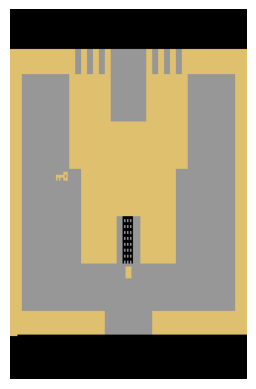

In [10]:
import matplotlib.pyplot as plt

plt.imshow(obs)
plt.axis('off')
plt.show()

# Preprocessing

Atari environments return raw pixel observations shaped like (210, 160, 3) (RGB), which are:

- Large in size (high memory & compute cost)
- Full of irrelevant visual details (e.g., score, borders, flicker)
- Temporally unstable (a single frame doesn’t show motion clearly)

What happens if we don’t preprocess? Training becomes very slow, or fails completely; the network will have a hard time extracting useful features and It may overfit to noise or irrelevant screen elements.

In [ ]:
# Preprocess frames (resize + grayscale)
def preprocess(obs):
    obs = Image.fromarray(obs)
    obs = obs.convert('L')  # grayscale
    obs = obs.resize((84, 84))  # downsample
    obs = np.array(obs) / 255.0  # normalize
    return obs

| Preprocessing Step                   | Why It's Done                                                  |
| ------------------------------------ | -------------------------------------------------------------- |
| **Grayscale**                        | Removes color, reducing input from 3 to 1 channel              |
| **Resizing (e.g., 210×160 → 84×84)** | Smaller input = faster training and less memory usage          |
| **Frame Stacking**                   | Shows motion by combining multiple consecutive frames          |
| **Pixel Normalization**              | Stabilizes training (values in `[0, 1]` instead of `[0, 255]`) |

## Solving the Environment

In [19]:
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # input: 4 stacked frames
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        return self.net(x)


In [23]:
num_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
memory = deque(maxlen=100_000)

In [24]:
def train_dqn():
    batch_size = 32
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.995
    update_target_every = 1000

    frame_stack = deque(maxlen=4)
    total_steps = 0

    for episode in range(5000):
        obs, _ = env.reset()
        obs = preprocess(obs)
        frame_stack = [obs] * 4  # initial 4-frame stack

        done = False
        total_reward = 0

        while not done:
            total_steps += 1
            state = torch.tensor(np.array(frame_stack), dtype=torch.float32).unsqueeze(0).cuda()

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = torch.argmax(q_values).item()

            next_obs, reward, done, truncated, _ = env.step(action)
            next_obs = preprocess(next_obs)
            frame_stack.append(next_obs)

            next_state = torch.tensor(np.array(frame_stack), dtype=torch.float32).unsqueeze(0).cuda()
            memory.append((state, action, reward, next_state, done))

            total_reward += reward

            # Training step
            if len(memory) > batch_size:
                minibatch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                states = torch.cat(states)
                next_states = torch.cat(next_states)
                actions = torch.tensor(actions).unsqueeze(1).cuda()
                rewards = torch.tensor(rewards).unsqueeze(1).cuda()
                dones = torch.tensor(dones, dtype=torch.uint8).unsqueeze(1).cuda()

                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                targets = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network
            if total_steps % update_target_every == 0:
                target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        print(f"Episode {episode} - Total Reward: {total_reward} - Epsilon: {epsilon:.3f}")


In [25]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from torchvision import transforms

# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 1000000
TARGET_UPDATE = 1000
MEMORY_SIZE = 100000
LR = 1e-4
NUM_FRAMES = 500000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess frames
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((84, 84)),
    transforms.ToTensor()
])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (np.stack(state), action, reward, np.stack(next_state), done)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # Input is 4 stacked grayscale frames
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = x / 255.0  # normalize pixel values
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def preprocess_frame(frame):
    return preprocess(frame).squeeze(0).numpy()

def stack_frames(stacked_frames, new_frame, is_new_episode):
    frame = preprocess_frame(new_frame)
    if is_new_episode:
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        stacked_frames.append(frame)
    return np.stack(stacked_frames, axis=0), stacked_frames

def select_action(state, steps_done, policy_net, num_actions):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if random.random() > eps_threshold:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return policy_net(state_tensor).max(1)[1].item()
    else:
        return random.randrange(num_actions)

# Initialize
env = gym.make("ALE/Adventure-v5", render_mode=None)
num_actions = env.action_space.n
policy_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayBuffer(MEMORY_SIZE)

steps_done = 0
episode_rewards = []

for episode in range(500):
    obs, _ = env.reset()
    state, stacked_frames = stack_frames(None, obs, True)
    total_reward = 0

    for t in range(10000):  # Max episode length
        action = select_action(state, steps_done, policy_net, num_actions)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state, stacked_frames = stack_frames(stacked_frames, next_obs, False)

        memory.push(state, action, reward, next_state, done)
        state = next_state
        steps_done += 1
        total_reward += reward

        # Training step
        if len(memory) > BATCH_SIZE:
            batch = memory.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = batch
            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).to(device)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach()
            expected_q = rewards + (GAMMA * next_q_values * (1 - dones))

            loss = nn.functional.mse_loss(q_values.squeeze(), expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            break

    episode_rewards.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

env.close()

# Plotting learning curve
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on Adventure-v5")
plt.savefig("adventure_dqn_rewards.png")
plt.show()

AttributeError: module 'numpy' has no attribute 'bool8'